### Introduction to Preprocessing and Training Stage 

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_for_modeling.csv')
df.head()

,P_Date,P_Date_str,DOW,GMST(m),GMS_pds_l10_dw,GMS_pds_l25_dw,GMS_pds_l10_stdev,GMS_pds_l25_stdev,GMST_Diff%_from_GMS_pds_l10_dw,GMS_per_constr_avg_past_diff_from_RPB,...,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay,overall_day_mean_GMST(m)
0,2024-02-03,2024-02-03,Saturday,22.583333,19.944848,21.907538,5.103116,4.545437,12.41,NaN,...,0,0,0,0,0,0,0,0,7.0,26.541479
1,2024-02-02,2024-02-02,Friday,18.783333,17.210909,17.334205,3.480521,2.455251,8.74,NaN,...,0,0,0,0,0,0,0,0,6.0,21.449373
2,2024-02-01,2024-02-01,Thursday,19.700000,15.780606,16.550718,2.244750,4.131868,22.09,7.74,...,0,0,0,0,0,0,0,0,5.0,20.709774
3,2024-01-31,2024-01-31,Wednesday,10.783333,11.621515,12.138103,2.338474,2.691352,-7.48,NaN,...,17,0,0,0,0,0,0,0,5.0,13.259712
4,2024-01-30,2024-01-30,Tuesday,7.383333,7.765758,7.783641,1.156256,1.306190,-5.05,-8.32,...,0,0,0,0,0,0,0,0,2.0,9.720614


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   P_Date                                 1596 non-null   object 
 1   P_Date_str                             1596 non-null   object 
 2   DOW                                    1596 non-null   object 
 3   GMST(m)                                1596 non-null   float64
 4   GMS_pds_l10_dw                         1595 non-null   float64
 5   GMS_pds_l25_dw                         1595 non-null   float64
 6   GMS_pds_l10_stdev                      1595 non-null   float64
 7   GMS_pds_l25_stdev                      1595 non-null   float64
 8   GMST_Diff%_from_GMS_pds_l10_dw         1595 non-null   float64
 9   GMS_per_constr_avg_past_diff_from_RPB  1071 non-null   float64
 10  GMS_per_constr_past_diff_from_RPB_ct   1596 non-null   float64
 11  GMS_

### Filter Data

In [5]:
#Remove the first solve period (2018)
df_filter = df.copy()
df_filter = df_filter[df_filter['P_Date_str'].str.contains("2019|2020|2021|2022|2023|2024")]

In [6]:
# Strip down to only the features we need to benchmark and the target feature
df_filter = df_filter[['overall_day_mean_GMST(m)', 'GMST(m)']]

In [46]:
df_filter[['GMST(m)']].mean()

GMST(m)    16.458145
dtype: float64

In [7]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 0 to 1595
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall_day_mean_GMST(m)  1595 non-null   float64
 1   GMST(m)                   1596 non-null   float64
dtypes: float64(2)
memory usage: 37.4 KB


Creating df variants with only the columns we will need to generate the benchmark models 

In [8]:
df_model1 = df_filter[['overall_day_mean_GMST(m)','GMST(m)']]

In [8]:
#df_model2 = df_filter[['IS1_ST(m)','overall_day_mean_IST(m)']]

In [9]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 0 to 1595
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall_day_mean_GMST(m)  1595 non-null   float64
 1   GMST(m)                   1596 non-null   float64
dtypes: float64(2)
memory usage: 37.4 KB


### Train Test Split

In [11]:
len(df_model1) * .75, len(df_model1) * .25

(1197.0, 399.0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1['GMST(m)'], test_size=0.25, 
                                                    random_state=47)

In [13]:
y_train.shape, y_test.shape

((1197,), (399,))

In [14]:
y_train

647      5.966667
106      7.950000
813     11.516667
851      5.916667
236     28.633333
          ...    
691     16.033333
584     14.350000
1288    13.133333
327      9.900000
1159    26.166667
Name: GMST(m), Length: 1197, dtype: float64

In [15]:
X_train.shape, X_test.shape

((1197, 1), (399, 1))

### Pre-Modeling: GMS Mean Solve Time Across All 15x15 Puzzles as Per Solve (GMST) Predictor (aka "Dummy Model")

In [16]:
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

16.438262322472887

In [17]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[16.43826232]])

In [18]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([16.43826232, 16.43826232, 16.43826232, 16.43826232, 16.43826232])

In [19]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [20]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -9.657932495432675e-05)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [21]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(6.875393649816548, 6.864602190522257)

#### Mean Squared Error (MSE)

In [22]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(68.60065193267211, 65.5003125364232)

#### Root Mean Squared Error (RMSE)

In [23]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(8.282551052222503, 8.093226336660997)

On average, we might expect to be off by around 8.39 minutes on training set data and 8.1 minutes on test data if you guessed the GMS solve time on a given 15x15 puzzle based simply on an average of known values.

Now instead of just guessing with the training set mean across all puzzle days, let's use a few benchmarks that at least take into consideration the default difficulty of a given puzzle based on it's puzzle day.

### Benchmark Linear Model 1: Puzzle Day-Specific, Whole-Sample Mean Global Median Solver (GMS) Solve Time as Sole Predictor of Individual GMSTs 

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 647 to 1159
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall_day_mean_GMST(m)  1196 non-null   float64
dtypes: float64(1)
memory usage: 18.7 KB


In [ ]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [ ]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [25]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [26]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [27]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [28]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [29]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000023E1A9A1310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [30]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

#### K Best Features Visualization

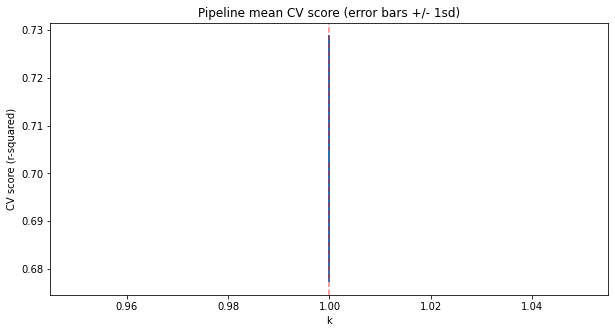

In [31]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Benchmark Model 1 Metrics

#### R-squared (COD)

In [32]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.68382101, 0.70045475, 0.68755993, 0.75128135, 0.69985673])

In [33]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.704594754476276, 0.024252672262980828)

#### Mean Absolute Error (MAE)

In [34]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [35]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(3.1420583026934206, 0.153004524764719)

In [36]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

3.046158717661146

#### Mean Squared Error (MSE)

In [37]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [38]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(20.220436386123254, 3.397510790608261)

In [39]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

17.128906564895015

#### Root Mean Square Error (RMSE)

In [40]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [41]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(4.48146007171366, 0.3700702794868247)

In [42]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

4.138708320828495

### Best Linear Model Feature Importance

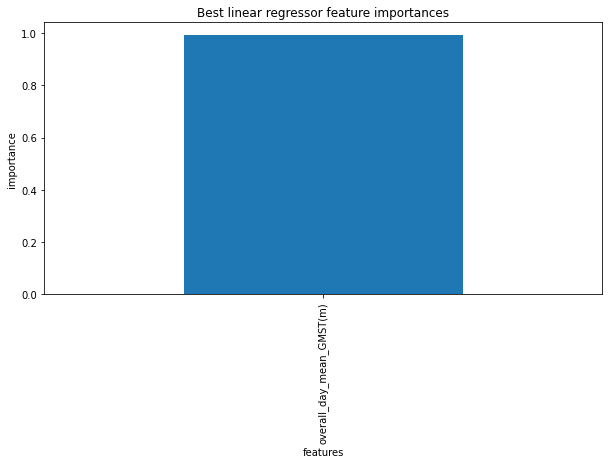

In [43]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [44]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'GMST_benchmark_linearmodel.pkl', modelpath)

Writing file.  "../models\GMST_benchmark_linearmodel.pkl"


### Save Prediction Metrics from Dummy Model and Benchmark Model 1

In [45]:
# save other data for model comparisons in machine learning model stage
comp_data_from4_GMST = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/GMST_benchmark.pickle', 'wb') as f:
    pickle.dump(comp_data_from4_GMST, f)

### Conclusions

Target feature predicted is GMS raw solve time in minutes. Measure reported here is RMSE.

* Dummy Model: 8.28 Train; 8.09 Test    
* Linear Model Using Global Median Solver Sample Mean Per Puzzle Day as Only Predictive Feature: 4.5(.37) Train; 4.14 Test

The benchmark model wildly outperforms the dummy model, which should be no surprise since it's the (whole sample) puzzle day specific mean. 

In [ ]:
(8.282551052222503, 8.093226336660997)

(4.48146007171366, 0.3700702794868247) 4.138708320828495